## UCLA Admission prediction- Logestic Regression

Here we're going to use logistic regression to estimate whether a student will be admited to the university based on the student's GPA and GRE score along with the rank indicating the prestige of the student's undergraduate institution.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.discrete.discrete_model import Logit
from scipy.special import logit
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r'ucla_binary.csv')

In [3]:
df.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [4]:
df.describe()

,admit,gre,gpa,rank
count,400.000000,400.000000,400.000000,400.00000
mean,0.317500,587.700000,3.389900,2.48500
std,0.466087,115.516536,0.380567,0.94446
min,0.000000,220.000000,2.260000,1.00000
25%,0.000000,520.000000,3.130000,2.00000
50%,0.000000,580.000000,3.395000,2.00000
75%,1.000000,660.000000,3.670000,3.00000
max,1.000000,800.000000,4.000000,4.00000


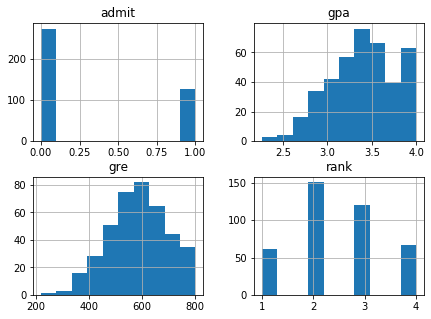

In [5]:
df.hist(figsize=(7,5))
plt.show()

Rank is ordinal variable. Here, we will convert to set of dummies which will then be used as a predictors in our logistic regression model.

In [6]:
dummy_ranks = pd.get_dummies(df['rank'], prefix='rank')
df = df.join(dummy_ranks)

In [7]:
#fitting the model
predictors = ['gpa', 'gre', 'rank_1', 'rank_2', 'rank_3', 'rank_4']
m = Logit(df['admit'], df[predictors])
m = m.fit()

Optimization terminated successfully.
         Current function value: 0.573147
         Iterations 6


In [8]:
m.params

gpa       0.804038
gre       0.002264
rank_1   -3.989979
rank_2   -4.665422
rank_3   -5.330183
rank_4   -5.541443
dtype: float64

In [9]:
print(m.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.083     
Dependent Variable: admit            AIC:              470.5175  
Date:               2020-05-21 12:18 BIC:              494.4663  
No. Observations:   400              Log-Likelihood:   -229.26   
Df Model:           5                LL-Null:          -249.99   
Df Residuals:       394              LLR p-value:      7.5782e-08
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
gpa        0.8040     0.3318    2.4231   0.0154    0.1537    1.4544
gre        0.0023     0.0011    2.0699   0.0385    0.0001    0.0044
rank_1    -3.9900     1.1400   -3.5001   0.0005   -6.2242   -1.7557
rank_2    -4.6654     1.

In [10]:
#estimate of odds
df['p'] = m.predict(df[predictors])

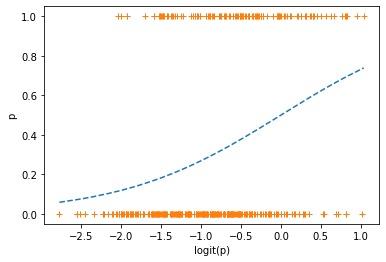

In [11]:
df = df.sort_values(by = ['p'])
plt.plot(logit(df.p), df.p, '--')
plt.plot(logit(df.p), df.admit, '+')
plt.xlabel('logit(p)')
plt.ylabel('p')
plt.show()

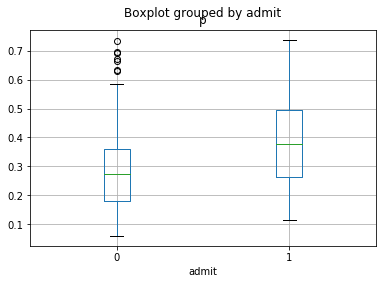

In [12]:
df.boxplot(column='p', by = 'admit')
plt.show()

In [13]:
df.loc[:, 'yhat'] = (df.p > 0.5) * 1
df.yhat.value_counts()

0    351
1     49
Name: yhat, dtype: int64

In [14]:
pd.crosstab(df.admit, df.yhat)

yhat,0,1
admit,,
0,254,19
1,97,30


In [15]:
#confusion matrix 
conf_mat = m.pred_table()
print (conf_mat)

[[254.  19.]
 [ 97.  30.]]


In [16]:
tn, fp, fn, tp = conf_mat.flatten()
print (tn, fp, fn, tp)

254.0 19.0 97.0 30.0


In [17]:
#accuracy
acc = (tp + tn) / np.sum(conf_mat)
print ("Accuraccy of the model is: %1.2f" % acc)

Accuraccy of the model is: 0.71


In [18]:
#Matthews correlation coefficient
mcc = (tp * tn - fp * fn)/np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))
print ("Mathews correlation coefficient between the estimates and the true response is: %1.2f" % mcc)

Mathews correlation coefficient between the estimates and the true response is: 0.24


In [19]:
#precision and recall
prc = tp / (tp + fp)
rec = tp / (tp + fn)
print ("Model's precision is %1.2f and it's recall is %1.2f" % (prc, rec))

Model's precision is 0.61 and it's recall is 0.24


In [20]:
#Set discrimination thresholds
ths = np.arange(0., 1.0, 0.025)

# Containers
sensitivity = []
specificity = []
accuracy = []
matthews = []

# Main loop
for th in ths:
    # Generate estimates
    conf_mat = m.pred_table(threshold=th)
    
    # Extract TN, FP, ...
    tn, fp, fn, tp = conf_mat.flatten()
    
    # Calculate sensitivity and specificity
    sens = (1. * tp) / (tp + fn)
    spec = (1. * tn) / (tn + fp)    
    
    # Calculate ACC and MCC
    acc = (tp + tn) / np.sum(conf_mat)
    mcc = (tp * tn - fp * fn)/np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))    

    # Add to containers
    sensitivity.append(sens)
    specificity.append(spec)
    accuracy.append(acc)
    matthews.append(mcc)

In [21]:
# Bind all the numbers together
roc = pd.DataFrame({'discret_thr' : ths, 
                    'sensitivity' : sensitivity, 
                    'specificity' : specificity,
                    '_specificity' : [1 - x for x in specificity],
                    'accuracy' : accuracy, 
                    'matthews' : matthews})

# Sort by 1 - specificity so we can plot it easily
roc = roc.sort_values(by = "_specificity").reset_index()

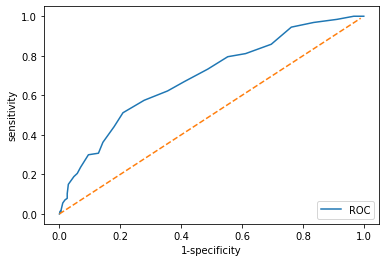

In [22]:
plt.plot(roc._specificity, roc.sensitivity, label = 'ROC')
plt.plot(np.arange(0., 1., 0.01), 
         np.arange(0., 1., 0.01), 
         '--')
plt.xlabel('1-specificity')
plt.ylabel('sensitivity')

plt.legend(loc = 4)

In [23]:
#Area Under Curve
auc = np.trapz(y = roc.sensitivity, x = roc._specificity)
print ("Area under ROC curve = %1.2f" % auc)

Area under ROC curve = 0.69


In [24]:
# Where threshold equal 0.5
idx_default_th = np.where(roc.discret_thr == 0.5)[0][0]

# Max sum of spec and sens
idx_youdensj = np.argmax(roc.sensitivity + roc.specificity)

 # Ballanced spec and sens
idx_ballance = np.argmin(np.abs(roc.sensitivity - roc.specificity))

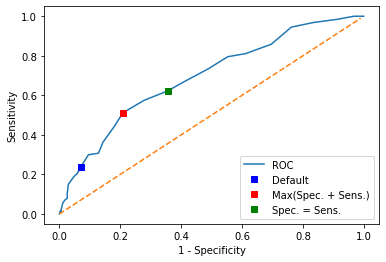

In [25]:
plt.plot(roc._specificity, roc.sensitivity, label = 'ROC')

plt.plot(np.arange(0., 1., 0.01), 
         np.arange(0., 1., 0.01), 
         '--')

plt.plot(roc._specificity[idx_default_th], 
         roc.sensitivity[idx_default_th], 
         's', color = 'blue',
         label = 'Default')

plt.plot(roc._specificity[idx_youdensj], 
         roc.sensitivity[idx_youdensj], 
         's', color = 'red',
         label = 'Max(Spec. + Sens.)')

plt.plot(roc._specificity[idx_ballance], 
         roc.sensitivity[idx_ballance], 
         's', color = 'green', 
         label = 'Spec. = Sens.')


plt.legend(loc = 4)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()

Confusion matrix at different points of the ROC curve

In [26]:
m.pred_table(threshold=roc.discret_thr[idx_youdensj])

array([[216.,  57.],
       [ 62.,  65.]])

In [27]:
m.pred_table(threshold=roc.discret_thr[idx_ballance])

array([[176.,  97.],
       [ 48.,  79.]])

Youden's J: The point on the ROC curve that is closest to the error-free point (0,1) is the point where the sum of sensitivity and specificity is maximimal. Therefore, the discrimination threshold corresponding to that point is often considered to be the optimal threshold. The vertical distance beween this point and the identity line is called Youden's J

In [28]:
J = max(roc.sensitivity + roc.specificity - 1)
print ('Youden\'s J = %1.2f' % J)

Youden's J = 0.30


In [29]:
print ('Odds mean: %1.2f' % np.mean(df['p']))
print ('Response mean: %1.2f' % np.mean(df['admit']))

Odds mean: 0.32
Response mean: 0.32


In [30]:
print ('Predicted positives #: %i' % np.sum(df['p'] > 0.5))
print ('True positives #: %i' % np.sum(df['admit'] > 0.5))

Predicted positives #: 49
True positives #: 127


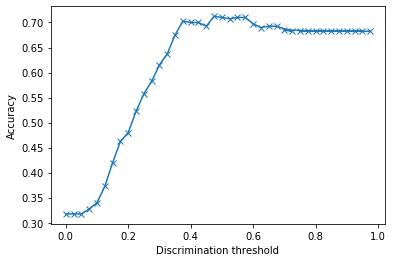

In [31]:
plt.plot(roc.discret_thr, roc.accuracy, 'x-')
plt.xlabel('Discrimination threshold')
plt.ylabel('Accuracy')
plt.show()

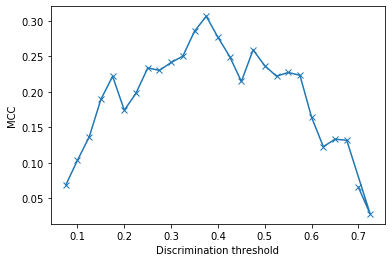

In [32]:
plt.plot(roc.discret_thr, roc.matthews, 'x-')
plt.xlabel('Discrimination threshold')
plt.ylabel('MCC')
plt.show()

In [33]:
idx_maxacc = np.argmax(roc.accuracy)
idx_maxmcc = np.argmax(roc.matthews)

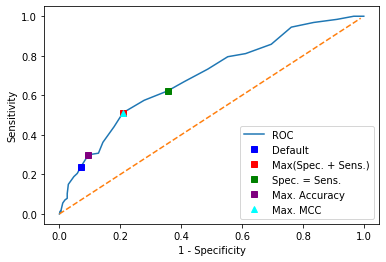

In [34]:
plt.plot(roc._specificity, roc.sensitivity, label = 'ROC')

plt.plot(np.arange(0., 1., 0.01), 
         np.arange(0., 1., 0.01), 
         '--')

plt.plot(roc._specificity[idx_default_th], 
         roc.sensitivity[idx_default_th], 
         's', color = 'blue',
         label = 'Default')

plt.plot(roc._specificity[idx_youdensj], 
         roc.sensitivity[idx_youdensj], 
         's', color = 'red',
         label = 'Max(Spec. + Sens.)')

plt.plot(roc._specificity[idx_ballance], 
         roc.sensitivity[idx_ballance], 
         's', color = 'green', 
         label = 'Spec. = Sens.')

plt.plot(roc._specificity[idx_maxacc], 
         roc.sensitivity[idx_maxacc], 
         's', color = 'purple',
         label = 'Max. Accuracy')

plt.plot(roc._specificity[idx_maxmcc], 
         roc.sensitivity[idx_maxmcc], 
         '^', color = 'cyan', 
         label = 'Max. MCC')

plt.legend(loc = 4)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()

As can be seen, the ROC point of maximal accuracy is quite distant from maximal MCC.

The maximal MCC is identical to maximum of the sum of specificity and sensitivity.

The ROC point of balanced senitivity and specificty differs from both maximal accuracy and maximal MCC.

This highlights the fact that the model's discrimination threshold can be optimized in multiple ways.
